# Linear Regression

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [8]:
may_data = pd.read_csv("../may_data.csv",parse_dates=["start_time","end_time"])
may_data.head(3)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,Month,duration,day
0,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5,0 days 00:17:00,31
1,628549,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,1207,Subscriber,5,0 days 00:17:00,31
2,628550,2016-05-31 23:56:00,2016-06-01 00:15:00,90,320,Millennium Park,Loomis St & Lexington St,4369,Subscriber,5,0 days 00:19:00,31


In [9]:
may_data_time = may_data
may_data_time["hour"] = may_data_time["start_time"].apply(lambda x: x.hour)
may_data_time["duration"] = (may_data_time["end_time"] - may_data_time["start_time"]).astype("timedelta64[m]")
may_data_time.head(3)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,Month,duration,day,hour
0,628548,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,609,Subscriber,5,17.0,31,23
1,628549,2016-05-31 23:57:00,2016-06-01 00:14:00,22,282,May St & Taylor St,Halsted St & Maxwell St,1207,Subscriber,5,17.0,31,23
2,628550,2016-05-31 23:56:00,2016-06-01 00:15:00,90,320,Millennium Park,Loomis St & Lexington St,4369,Subscriber,5,19.0,31,23


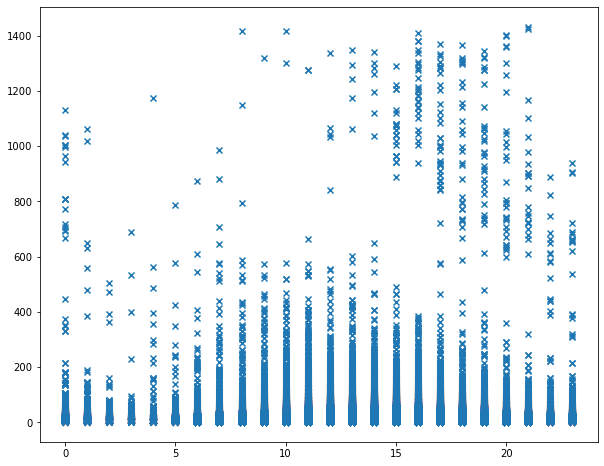

In [11]:
plt.figure(figsize=(10,8))
plt.scatter(may_data_time["hour"],may_data_time["duration"],marker="x")

In [22]:
# resample the data to trips per hour per day
may_hour_day = may_data_time[["start_time","duration","start_station_id"]].resample("H",on="start_time").agg({"duration":"mean","start_station_id":"count"})
may_hour_day["hour"] = may_hour_day.index.to_series().apply(lambda x:x.hour)
may_hour_day["day"] = may_hour_day.index.to_series().apply(lambda x:x.day)
may_hour_day.rename(columns={"start_station_id":"number_of_trips"},inplace=True)
may_hour_day.head(3)

,duration,number_of_trips,hour,day
start_time,,,,
2016-05-01 00:00:00,8.840000,25,0,1
2016-05-01 01:00:00,9.263158,19,1,1
2016-05-01 02:00:00,9.900000,20,2,1


C:\Users\Adrian\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


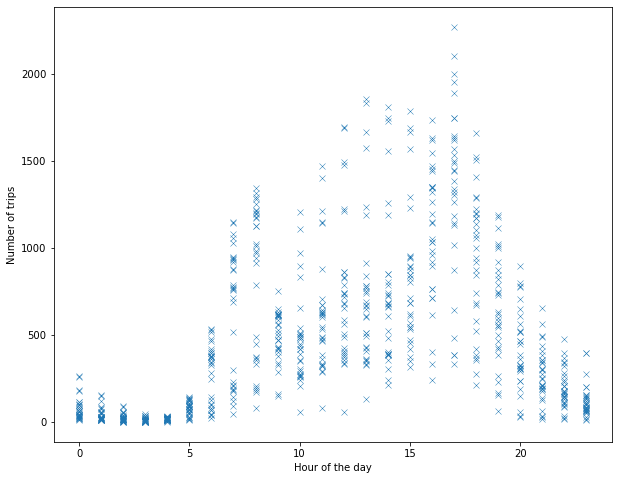

In [83]:
plt.figure(figsize=(10,8))
plt.xlabel("Hour of the day")
plt.ylabel("Number of trips")
sns.scatterplot(may_hour_day["hour"],may_hour_day["number_of_trips"],marker="x")
plt.show()

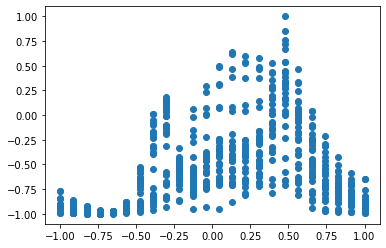

In [38]:
def standardize(x):
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1
    return xs

x = may_hour_day["hour"].values
x = standardize(x)
y = may_hour_day["number_of_trips"].values
y = standardize(y)
plt.scatter(x,y)

0.08621074322099329
0.21410585316394937
0.4982763763408039


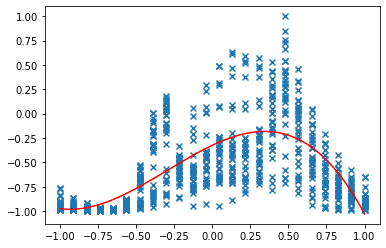

In [96]:
def regr(d):
    #create features
    PF = PolynomialFeatures(degree = d,interaction_only = False, include_bias = True)
    hour_poly = PF.fit_transform(x.reshape(-1,1))
    # create regression
    regression = LinearRegression()
    #normalize values
    regression.fit(hour_poly,y)
    #create curve
    reg_line_points = np.linspace(-1,1,400)
    trans_curve = PF.fit_transform(reg_line_points.reshape(-1,1))
    reg_curve = regression.predict(trans_curve)

    plt.plot(reg_line_points,reg_curve,color="red")
    plt.scatter(x,y,marker="x")
    print(mean_squared_error(y,regression.predict(hour_poly)))
    print(mean_absolute_error(y,regression.predict(hour_poly)))
    print(r2_score(y,regression.predict(hour_poly)))
regr(3)

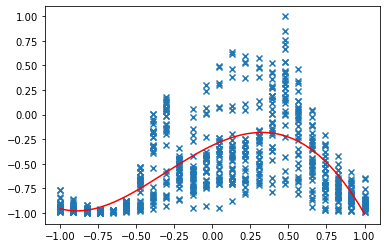

In [76]:
regr(4)

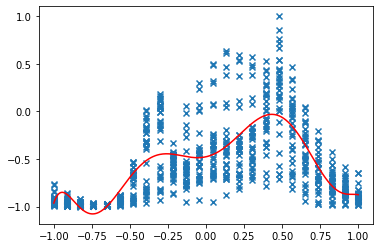

In [77]:
regr(8)

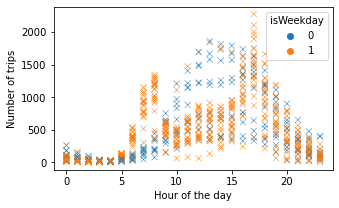

In [97]:
#add isWeekday feature
may_hour_day["isWeekday"] = may_hour_day.index.to_series().apply(lambda x: 1 if x.weekday() <= 4 else 0)
may_hour_day.head(3)
plt.figure(figsize=(5,3))
plt.xlabel("Hour of the day")
plt.ylabel("Number of trips")
sns.scatterplot(data=may_hour_day,x="hour",y="number_of_trips",marker="x",hue="isWeekday")
plt.show()

110913.76787952069
244.99613386288914
0.49981350983462824


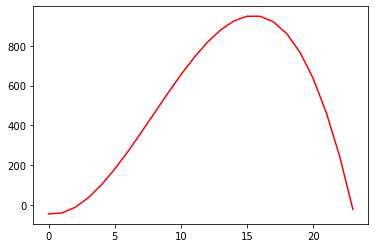

In [152]:
#add weekday feature to model -> not quite shure it worked :|
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler();
x_mult = may_hour_day[["hour","isWeekday"]]
y_mult = may_hour_day["number_of_trips"]
#x_mult = scaler.fit(x_mult).transform(x_mult)
#create features
PF = PolynomialFeatures(degree = 3,interaction_only = False, include_bias = True)
hour_poly_mult = PF.fit_transform(x_mult)
# create regression
regression = LinearRegression()

regression.fit(hour_poly_mult,y_mult)
#create curve
reg_line_points = np.empty((24,2))
i = 0;
for a in np.arange(0,24,1):
    #all Weekend
    reg_line_points[i] = np.array([a,0])
    i = i+1
    
line_df = pd.DataFrame(reg_line_points, columns=["hour","isWeekday"])

poly_curve = PF.fit_transform(line_df)
reg_curve = regression.predict(poly_curve)

plt.plot(np.arange(0,24,1),reg_curve,color="red")
print(mean_squared_error(y_mult,regression.predict(hour_poly_mult)))
print(mean_absolute_error(y_mult,regression.predict(hour_poly_mult)))
print(r2_score(y_mult,regression.predict(hour_poly_mult)))